# Notebook #5: Modelado de los datos

In [11]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import pickle
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Para realizar la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

# Librería para el acceso a variables y funciones
# -----------------------------------------------------------------------
import sys
sys.path.append("../../../../")
from src import soporte_modelos as sm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- El primer paso consiste en cargar los datos ya estandarizados.

In [19]:
df = pd.read_pickle('../../../../datos/cluster0/modelo1/df_scaled')
df.sample(5)

,Profit,Ship Mode,Country,Market,Region,Category,Sub-Category,Quantity,Discount,Order Priority
3929,48.7011,-0.500886,-0.202264,-0.838177,-0.335558,1.032808,0.012213,1.721432,0.277499,1.008626
9837,16.7776,-1.006528,-0.202264,-0.838177,-0.386001,-1.798043,-0.805452,0.300134,-0.732116,-1.991116
15071,5.2800,-1.321221,0.875875,1.122893,-0.048244,-1.798043,-1.355320,-0.647398,-0.732116,-1.991116
4705,6.2400,-1.006528,1.306105,1.197808,2.515868,1.032808,0.012213,2.195198,-0.732116,0.166054
14262,10.0572,-1.321221,-0.202264,-0.838177,-0.763207,-1.798043,-1.032974,1.247666,0.277499,-1.991116


- Para nuestros modelos, utilizaremos el Decision Tree y otros tres modelos de ensamble: el Random Forest, el Gradient Boost y el XGBoost, que se usan en modelos de clasificación y de regresión.

- Nuestro problema es de regresión, por cuanto estamos intentando predecir valores continuos, en este caso, el beneficio. Un valor continuo es un tipo de dato numérico que puede tomar cualquier valor dentro de un rango determinado.

- Los Decision Tree son especialmente efectivos en problemas con interacciones no lineales y datos con diferentes tipos de variables (numéricas y categóricas). Son robustos frente a outliers y pueden gestionar conjuntos con valores faltantes. Sin embargo, son propensos al overfitting. Es entonces cuando podemos recurrir a los modelos de ensamble, para mejorar su estabilidad y precisión.

- El Random Forest puede funcionar mejor cuando tenemos conjuntos de datos grandes o mucho ruido en nuestros datos, pero puede ser menos efectivo para captar variaciones más pequeñas. Es más sencillo configurar los hiperparámetros. Es un modelo de Bagging, donde creamos un bosque (paralelo), no nos quedamos con un sólo árbol, y el resultado es la media de sus medias.

- Con Gradient Boosting, las predicciones suelen ser más acertadas, dado que la secuencia árboles tiende a reducir los errores. Normalmente tarda más para converger. Es más probable tener overfitting. En los modelos de Boosting, se aprende de los datos en la primera iteración (se predice la variable respuesta) pero en las posteriores, aprende de los errores cometidos, que son los que entran en el siguiente árbol, siendo el resultado final el del último árbol.

- La versión optimizada de este último modelo es el XGBoost, que utiliza paralelización (mejora tanto la velocidad como la eficiencia computacional), para maximizar la eficiencia y la precisión general del modelo.
________________________

- Como primer paso, separamos la X y la y de nuestro conjunto de datos.

In [5]:
X = df.drop("Profit", axis = 1)
y = df[["Profit"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

- Definimos un diccionario de hiperparámetros conjunto para todos los modelos.

In [ ]:
parametros_default = {
    "tree": {
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5]
    },
    "random_forest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5]
    },
    "gradient_boosting": {
        'n_estimators': [100, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.8, 1.0]
    },
    "xgboost": {
        'n_estimators': [100, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
}

- Antes de probar nuestros modelos, recordemos cómo interpretamos las métricas resultantes, específicamente el R2 y el RMSE, ambas son utilizadas para evaluar la precisión de los modelos de regresión.

- El R2 indica en qué porcentaje las variaciones en el modelo son explicadas por sus variables independientes. Con valores que van de 0 a 1, un valor más cercano a 1 indica un mejor ajuste del modelo.

- Por otro lado, el RMSE mide la magnitud de los errores de predicción, representando la desviación estándar de las diferencias entre los valores predichos y los observados. Un valor más bajo de RMSE indica una mejor predicción. 

- Con esto claro, empezamos las pruebas.

## Decision Tree

In [12]:
modelo_final_tree, df_metricas_tree = sm.probar_modelo(X, y["Profit"].values, X_test, y_test, parametros_default["tree"], DecisionTreeRegressor())

Los mejores parámetros para el modelo con DecisionTreeRegressor() son:
    {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2}
    

    Y sus mejores métricas son:


,r2_score,MAE,MSE,RMSE
train,0.405537,63.405311,9723.699197,98.608819
test,0.400939,63.978767,9998.831706,99.994158


In [27]:
print(f'Media de beneficio: {round(df["Profit"].mean(),2)}')

Media de beneficio: 41.08


- El resultado es malo, especialmente el R2, que nos está indicando que, las variables del modelo sólamente explican en un 40% los cambios en el modelo.

- En el caso del RSME, tenemos una desviación de 100 unidades monetarias, que es alta.

- No tenemos overfitting, es decir, el modelo no está aprendiéndose los datos.

## Random Forest

In [13]:
modelo_final_rf, df_metricas_rf = sm.probar_modelo(X, y["Profit"].values, X_test, y_test, parametros_default["random_forest"], RandomForestRegressor())

Los mejores parámetros para el modelo con RandomForestRegressor() son:
    {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 200}
    

    Y sus mejores métricas son:


,r2_score,MAE,MSE,RMSE
train,0.533137,54.725264,7636.530000,87.387242
test,0.527518,55.448061,7886.117054,88.803812


- En este caso, los resultados han mejorado significativamente, con un R2 que aumenta y un RMSE menor. En el caso del R2, quiere decir que, poco más de la mitad de los cambios en la variable respuesta (profit) pueden ser predichas por el modelo, mientras que la otra mitad se debe a factores no capturados por el modelo.

- Veamos la importancia de nuestras variables predictoras:

In [14]:
df_importancia_rf = pd.DataFrame(modelo_final_rf.feature_importances_, columns= ["Importancia"], index=X.columns).sort_values(by="Importancia", ascending = False)
df_importancia_rf

,Importancia
Discount,0.516725
Sub-Category,0.188509
Quantity,0.148028
Country,0.057952
Ship Mode,0.023918
Order Priority,0.020037
Region,0.019316
Market,0.017034
Category,0.008481


<Axes: xlabel='Importancia', ylabel='None'>

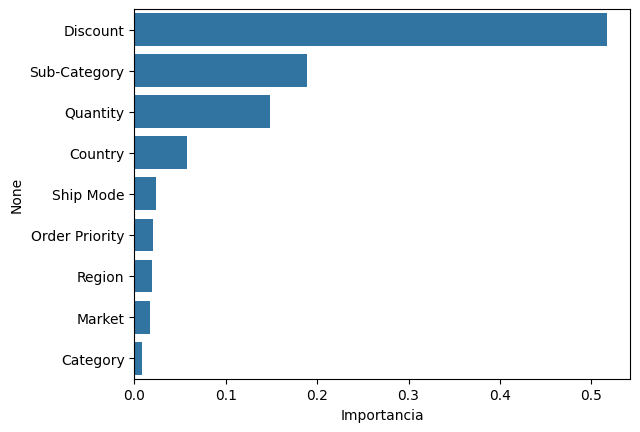

In [15]:
sns.barplot(x = "Importancia", y= df_importancia_rf.index, data = df_importancia_rf)

- Vemos que, con diferencia, discount es la variable predictora más importante, mientras que hay un grupo de ellas -Ship Mode, Order Priority, Region, Market y Category- que, en conjunto, sólo explican un 8% de los cambios en el modelo.

- Vamos a eliminarlas y probar si obtenemos un mejor resultado.

In [29]:
columnas_a_eliminar = ['Ship Mode','Market','Region','Order Priority','Category']

X_train_reducida = X_train.drop(columns=columnas_a_eliminar)
X_test_reducida = X_test.drop(columns=columnas_a_eliminar)

- Ahora reentrenamos al modelo, ajustando ligeramente los parámetros.

In [31]:
modelo_final_rf_v2, df_metricas_rf_v2 = sm.probar_modelo(X_train_reducida, y_train["Profit"].values, X_test_reducida, y_test, parametros_default["random_forest"], RandomForestRegressor())

Los mejores parámetros para el modelo con RandomForestRegressor() son:
    {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
    

    Y sus mejores métricas son:


,r2_score,MAE,MSE,RMSE
train,0.516563,55.543117,7837.491615,88.529609
test,0.423744,61.021658,9618.194497,98.072394


- Vemos que, las métricas han disminuido, así que, no sería este el acercamiento correcto (eliminar variables). Vemos que, además, tenemos un poco de overfitting.

## Gradient Boost

In [16]:
modelo_final_gb, df_metricas_gb = sm.probar_modelo(X, y["Profit"].values, X_test, y_test, parametros_default["gradient_boosting"], GradientBoostingRegressor())

Los mejores parámetros para el modelo con GradientBoostingRegressor() son:
    {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}
    

    Y sus mejores métricas son:


,r2_score,MAE,MSE,RMSE
train,0.485508,57.544467,8415.591457,91.736533
test,0.476538,58.296349,8737.024974,93.472055


- Damos otro paso atrás, y vemos que, tanto el R2 como el RMSE han empeorado, aunque se mantienen cercanos a los resultados obtenidos de los otros modelos.

## XGBoost

In [17]:
modelo_final_xgb, df_metricas_xgb = sm.probar_modelo(X, y["Profit"].values, X_test, y_test, parametros_default["xgboost"], XGBRegressor())

Los mejores parámetros para el modelo con XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...) son:
    {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}
    

    Y sus mejores métricas son:


,r2_score,MAE,MSE,RMSE
train,0.508202,56.354691,8044.384112,89.690491
test,0.500585,57.132333,8335.661379,91.299843


- Por velocidad y resultados, tenemos aquí a nuestro mejor modelo, aunque seguimos teniendo problemas de un R2 bajo. Las métricas son similares al Random Forest, ligeramente inferiores, pero con un tiempo de cómputo casi 3/4 menor.

- Procedemos entonces a guardar el objeto del modelo.

In [32]:
with open('../../../../transformers/cluster0_model.pkl', 'wb') as f:
      pickle.dump(modelo_final_xgb, f)